In [405]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
import segmentation_models_pytorch as smp
from matplotlib.colors import ListedColormap
import rasterio

In [406]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [407]:
models= {}

In [408]:
deeplabV3_model = smp.DeepLabV3Plus(
encoder_name = 'resnet34',
encoder_weights = None,
in_channels = 4,
classes = 1,
activation='sigmoid'
).to(device)

state_dict = torch.load('./final_models/deeplabv3.pth', map_location=device)
deeplabV3_model.load_state_dict(state_dict)
deeplabV3_model.to(device)
deeplabV3_model.eval()
models['deeplabV3_model'] = deeplabV3_model

In [409]:
unetplusplus_model = smp.UnetPlusPlus(
encoder_name = 'resnet34',
encoder_weights = None,
in_channels = 4,
classes = 1,
activation='sigmoid'
).to(device)

state_dict = torch.load('./final_models/unetplusplus.pth', map_location=device)
unetplusplus_model.load_state_dict(state_dict)
unetplusplus_model.to(device)
unetplusplus_model.eval()
models['unetplusplus_model'] = unetplusplus_model

In [410]:
unet_model = smp.Unet(
encoder_name = 'resnet34',
encoder_weights = None,
in_channels = 4,
classes = 1,
activation='sigmoid'
).to(device)

state_dict = torch.load('./final_models/unet.pth', map_location=device)
unet_model.load_state_dict(state_dict)
unet_model.to(device)
unet_model.eval()
models['unet_model'] = unet_model

In [411]:
fpn_model = smp.FPN(
encoder_name = 'resnet34',
encoder_weights = None,
in_channels = 4,
classes = 1,
activation='sigmoid'
).to(device)

state_dict = torch.load('./final_models/fpn.pth', map_location=device)
fpn_model.load_state_dict(state_dict)
fpn_model.to(device)
fpn_model.eval()
models['fpn_model']= fpn_model

In [412]:
pan_model = smp.PAN(
encoder_name = 'resnet34',
encoder_weights = None,
in_channels = 4,
classes = 1,
activation='sigmoid'
).to(device)

state_dict = torch.load('./final_models/pan.pth', map_location=device)
pan_model.load_state_dict(state_dict)
pan_model.to(device)
pan_model.eval()
models['pan_model']=pan_model

In [413]:
eval_root="AMAZON/Test"

In [414]:
mean = torch.tensor([0.485, 0.456, 0.406, 0.5])
std  = torch.tensor([0.229, 0.224, 0.225, 0.5])
preprocess = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.Normalize(mean,std),
])
preprocess_mask = transforms.Compose([
    transforms.Resize((256,256))
])

class EvalDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'image')
        self.mask_dir = os.path.join(root_dir, 'label')

        self.image_names = sorted(os.listdir(self.image_dir))
        self.mask_names = sorted(os.listdir(self.mask_dir))

        # --- Add a check here to ensure image and mask names correspond ---
        print(len(self.image_names), len(self.mask_names))
        if len(self.image_names) != len(self.mask_names):
            raise ValueError("Number of images and masks do not match.")

        # More rigorous check if filenames are expected to be identical
        # For example, if image_001.jpg corresponds to mask_001.png
        # You might want to strip extensions for comparison or ensure specific naming conventions
        for i in range(len(self.image_names)):
            img_base = os.path.splitext(self.image_names[i])[0]
            mask_base = os.path.splitext(self.mask_names[i])[0]
            if img_base != mask_base:
                print(f"Warning: Image '{self.image_names[i]}' and mask '{self.mask_names[i]}' have different base names. Ensure they correspond correctly.")
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, index):
        image_path = os.path.join(self.image_dir, self.image_names[index])
        mask_path = os.path.join(self.mask_dir, self.mask_names[index])
        with rasterio.open(image_path) as src:
            image = src.read()  # (C, H, W)
        
        # Normalize
        image = torch.from_numpy(image).float()
        image = (image / 10000)
        
       
        image = self.transform(image)
        
        mask = Image.open(mask_path).convert("L") 
        mask = mask.resize((256, 256)) 
        mask = np.array(mask)
        return image, mask
    
evaldata = EvalDataset(eval_root, preprocess)
evalloader = DataLoader(evaldata, batch_size=1, shuffle=True, num_workers=1, pin_memory=True)

20 20


In [415]:
def predict (model, img):

    model.eval()
    with torch.no_grad():
        pred = model(img.to(device))
   
    pred = pred.cpu().squeeze().numpy()
    return pred

In [416]:
def calculate_metrics(pred, gt):
    # Sicherstellen: alles Tensors
    if isinstance(gt, np.ndarray):
        gt = torch.from_numpy(gt).long()
    if isinstance(pred, np.ndarray):
        pred = torch.from_numpy(pred).long()


    pred = torch.argmax(pred, dim=1)  # B,H,W

    tp = ((pred==1) & (gt==1)).sum().float()
    fp = ((pred==1) & (gt==0)).sum().float()
    fn = ((pred==0) & (gt==1)).sum().float()

    iou = (tp / (tp + fp + fn + 1e-6)).item()
    dice = (2*tp / (2*tp + fp + fn + 1e-6)).item()
    acc = ((pred==gt).float().mean()).item()
    precision = (tp / (tp + fp + 1e-6)).item()
    recall = (tp / (tp + fn + 1e-6)).item()

    return {"iou": iou, "dice": dice, "acc": acc,
            "precision": precision, "recall": recall}



In [417]:
def plot_dataset_entry(img, mask, ground_truth, show_mask=True):

    colors = [
    (1.0, 1.0, 1.0),  # 0 = background -> weiß
    (0.0, 0.6, 0.0),  # 1 = trees -> grün
    ]
    cmap = ListedColormap(colors)
 
    plt.figure(figsize=(12,6))

    # Originalbild
    plt.subplot(1,4,1)

    img = img.squeeze(0).numpy()
    gamma = 0.4  # <1 = heller
    img = img ** gamma

    img = np.moveaxis(img, 0, -1)

    #img = (img/2000).clip(0, 1)
    plt.imshow(img[:,:,:3])
    plt.title("Original Image")
    plt.axis("off")

    # Vorhersagemaske
    if show_mask:
        plt.subplot(1,4,2)
        plt.imshow(mask, cmap=cmap, vmin=0, vmax=1)
        plt.title("Predicted Mask")
        plt.axis("off")

    ground_truth = ground_truth.numpy()
    ground_truth = np.moveaxis(ground_truth,0,-1)
    plt.subplot(1,4,3)
    plt.imshow(ground_truth, cmap=cmap, vmin=0, vmax=1)
    plt.title("Ground Truth")
    plt.axis("off")
    
    # Vorhersage-Klassen-Verteilung
    plt.subplot(1,4,4)
    unique, counts = np.unique(mask, return_counts=True)
    plt.bar(unique, counts)
    plt.title("Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Pixel Count")
    plt.grid(True, alpha=0.3)

    plt.show()

In [418]:
import pandas as pd

rows = []

for model_name, model in models.items():
    for idx, (img, mask) in enumerate(evalloader):
        pred = predict(model, img)
        metrics = calculate_metrics(pred, mask)

        row = {
            "model": model_name,
            "image_idx": idx,
            **metrics  # expand dict
        }
        rows.append(row)

df = pd.DataFrame(rows)

In [419]:
df.head()

,model,image_idx,iou,dice,acc,precision,recall
0,deeplabV3_model,0,0.0,0.0,0.464508,0.0,0.0
1,deeplabV3_model,1,0.0,0.0,0.515686,0.0,0.0
2,deeplabV3_model,2,0.0,0.0,0.338211,0.0,0.0
3,deeplabV3_model,3,0.0,0.0,0.443466,0.0,0.0
4,deeplabV3_model,4,0.0,0.0,0.430344,0.0,0.0


In [420]:
df

,model,image_idx,iou,dice,acc,precision,recall
0,deeplabV3_model,0,0.000000,0.000000,0.464508,0.000000,0.000000
1,deeplabV3_model,1,0.000000,0.000000,0.515686,0.000000,0.000000
2,deeplabV3_model,2,0.000000,0.000000,0.338211,0.000000,0.000000
3,deeplabV3_model,3,0.000000,0.000000,0.443466,0.000000,0.000000
4,deeplabV3_model,4,0.000000,0.000000,0.430344,0.000000,0.000000
...,...,...,...,...,...,...,...
95,pan_model,15,0.000000,0.000000,0.597351,0.000000,0.000000
96,pan_model,16,0.000000,0.000000,0.357559,0.000000,0.000000
97,pan_model,17,0.011043,0.021844,0.184692,0.992188,0.011043
98,pan_model,18,0.000000,0.000000,0.326233,0.000000,0.000000


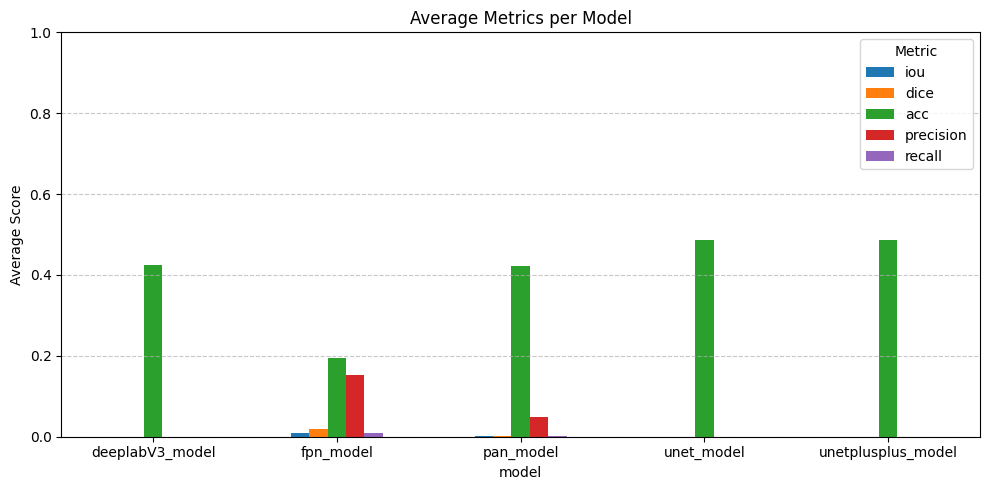

In [421]:
def plot_average_metrics(df, metrics=None):
  
    if metrics is None:
        metrics = ["iou", "dice", "acc", "precision", "recall"]

    # Mittelwert pro Modell berechnen
    mean_df = df.groupby("model")[metrics].mean().reset_index()

    # Balkendiagramm plotten
    mean_df.plot(x="model", y=metrics, kind="bar", figsize=(10,5), rot=0)
    plt.ylim(0, 1)
    plt.ylabel("Average Score")
    plt.title("Average Metrics per Model")
    plt.legend(title="Metric")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_average_metrics(df)

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0

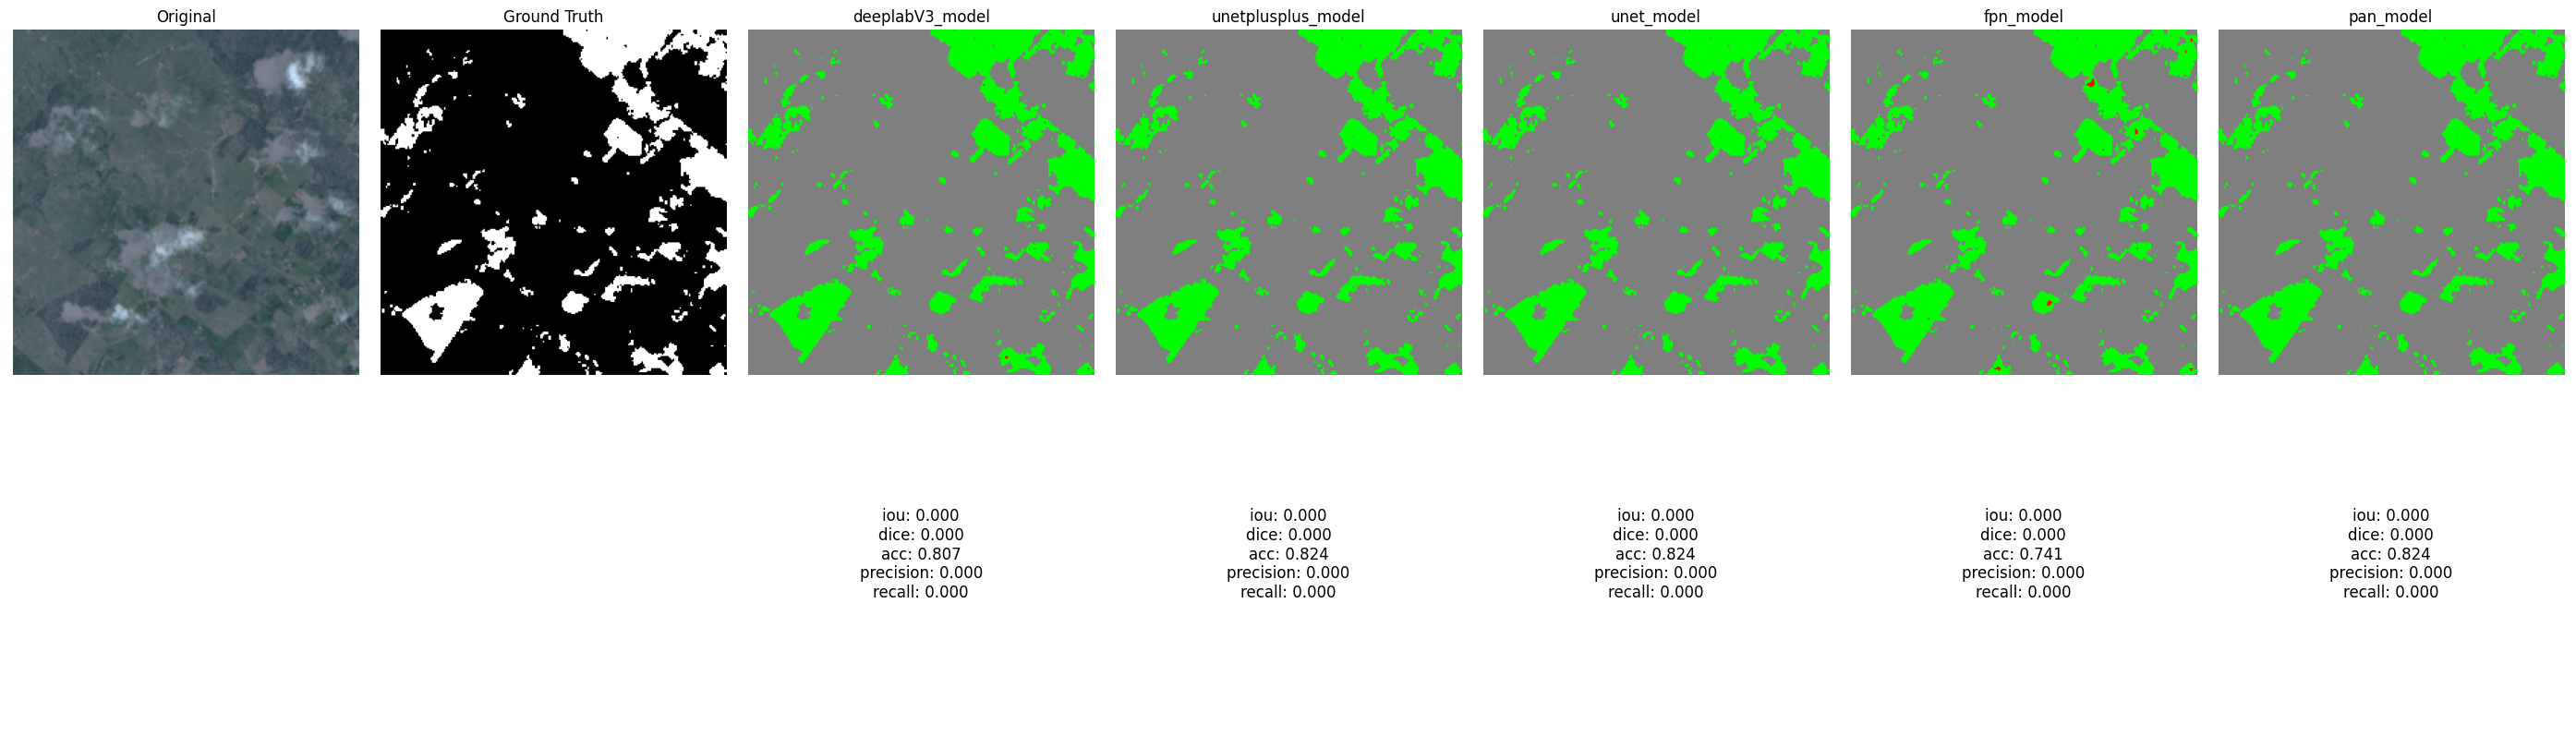

In [422]:
def plot_image_comparison(models, dataloader, image_idx):

    img, gt = None, None
    for idx, (i, m) in enumerate(dataloader):
        if idx == image_idx:
            img = i
            gt = m
            break
    if img is None:
        raise ValueError(f"Image index {image_idx} not found in DataLoader.")

    if torch.is_tensor(img):
        img_plot = img.squeeze().cpu().numpy()
   
        img_plot = np.transpose(img_plot, (1,2,0))
       
        img_plot = (img_plot - img_plot.min()) / (img_plot.max() - img_plot.min() + 1e-8)
    else:
        img_plot = np.array(img)

    # Ground Truth in Tensor  
    gt_tensor = gt.long()
    gt_plot = gt_tensor.squeeze().cpu().numpy()

    num_models = len(models)
    fig, axes = plt.subplots(2, num_models+2, figsize=(4*(num_models+2), 8))

    # Originalbild
    axes[0,0].imshow(img_plot)
    axes[0,0].set_title("Original")
    axes[0,0].axis("off")
    axes[1,0].axis("off")  # Platz für Metriken

    # Ground Truth
    axes[0,1].imshow(gt_plot, cmap="gray")
    axes[0,1].set_title("Ground Truth")
    axes[0,1].axis("off")
    axes[1,1].axis("off")


    for col_idx, (name, model) in enumerate(models.items(), start=2): 
        # Prediction
        pred = predict(model, img)
            
        if not torch.is_tensor(pred):
            pred = torch.from_numpy(pred)
        pred = pred.long().cpu()
        print(pred)

        # Metrics
        metrics = calculate_metrics(pred, gt_tensor)
        
        if pred.ndim > 2:
            pred = pred.squeeze()
        if gt_tensor.ndim > 2:
            gt_tensor = gt_tensor.squeeze()

        H, W = pred.shape
        heatmap = torch.ones((H, W, 4), dtype=torch.float32)  # TN = weiß
        pred = 1- pred
        # Boolean Masken
        tp = (pred==1) & (gt_tensor==1)
        fn = (pred==0) & (gt_tensor==1)
        fp = (pred==1) & (gt_tensor==0)
        tn = (pred==0) & (gt==0)

        # RGB setzen
        def set_rgb(mask, color):
            mask = mask.squeeze()  # sicherstellen, dass 2D
            rows, cols = mask.nonzero(as_tuple=True)
            heatmap[rows, cols, 0] = color[0]
            heatmap[rows, cols, 1] = color[1]
            heatmap[rows, cols, 2] = color[2]

        set_rgb(tp, [0,1,0])      # grün
        set_rgb(fn, [1,0,0])      # rot
        set_rgb(fp, [0.5,0.5,0.5]) # grau
        set_rgb(tn, [1,1,1])

        # 4. Plotten
        axes[0,col_idx].imshow(heatmap.numpy())
        axes[0,col_idx].set_title(name)
        axes[0,col_idx].axis("off")

        # Metrics darunter
        metrics_text = "\n".join([f"{k}: {v:.3f}" for k,v in metrics.items()])
        axes[1,col_idx].text(0.5, 0.5, metrics_text, ha="center", va="center", fontsize=12)
        axes[1,col_idx].axis("off")

    plt.tight_layout()
    plt.show()
plot_image_comparison(models, evalloader, image_idx=5)